In [18]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

from nltk.tokenize import word_tokenize 
  

In [ ]:
stop_words = set(stopwords.words('english'))
def rem_stopwords(s):
    
    word_tokens = word_tokenize(s) 
  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  
    filtered_sentence = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
        filtered_sentence.append(w) 
    

In [19]:
df = pd.read_csv('reviews.csv')
df.isnull().values.any() # checks if data file have any null values
df.head()

,reviews,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [4]:
def preprocess(text):
  text = re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
  text = re.sub('[\W]+', ' ', text.lower()) +\
      ' '.join(emoticons).replace('-', '')
  return text


In [5]:
X = []
sentences = list(df['reviews'])
for sen in sentences:
    X.append(preprocess(sen))
y = df['sentiment']

# Train( 80 ) Test( 20 ) Split

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Embedding Layer ( For converting textual data into numeric data )

* First layer in DL model in Keras

In [158]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(len(X_train[1]))
print(len(X_test[1]))

158
233


In [159]:
print(X_train[2])

[10, 202, 29, 1, 89, 348, 19, 9, 123, 210, 1, 63, 1164, 9, 50, 132, 44, 7, 6, 11, 2501, 9, 155, 21, 969, 5, 65, 7, 71, 69, 359, 3, 873, 773, 8, 358, 2, 285, 8, 1, 300, 41, 1738, 39, 2930, 1515, 51, 1, 243, 60, 376, 10, 412, 4, 2502, 6, 3, 905, 742, 95, 97, 195, 19, 1, 815, 323, 22, 135, 234, 1, 15, 548, 44, 163, 1645, 5, 988, 1, 63, 669, 35, 50, 29, 919, 8, 10, 19, 24, 146, 35, 438, 66, 2801, 2, 181, 5, 118, 135, 32, 232, 167, 48, 4, 1, 2656, 219, 3, 279, 232, 27, 90, 34, 219, 617, 4, 10, 18, 9, 797, 7, 1, 2656, 592, 69, 23, 1767, 8, 99, 95, 14, 7, 6, 7, 6, 41, 3, 1605, 196, 5, 2, 5, 29, 3, 173, 4, 786, 10, 19, 30, 99, 2128]


In [160]:
# padding process 
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [161]:
print(len(X_train[1]))
print(len(X_test[1]))

100
100


In [162]:
print(vocab_size) # number of unique words in dataset

94320


In [163]:
# using GloVe for creating feature matrix
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [164]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [165]:
len(embedding_matrix)

94320

# Text Classification with Recurrent Neural Network (LSTM)

In [166]:
from keras.layers import LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(200))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [167]:
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 100)          9432000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               240800    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 9,673,001
Trainable params: 241,001
Non-trainable params: 9,432,000
_________________________________________________________________
None


In [168]:
history = model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/7
32000/32000 [==============================] - 79s 2ms/step - loss: 0.5702 - acc: 0.7004 - val_loss: 0.4687 - val_acc: 0.7779
Epoch 2/7
32000/32000 [==============================] - 78s 2ms/step - loss: 0.4228 - acc: 0.8077 - val_loss: 0.4031 - val_acc: 0.8175
Epoch 3/7
32000/32000 [==============================] - 79s 2ms/step - loss: 0.3794 - acc: 0.8290 - val_loss: 0.3997 - val_acc: 0.8186
Epoch 4/7
32000/32000 [==============================] - 82s 3ms/step - loss: 0.3446 - acc: 0.8488 - val_loss: 0.3566 - val_acc: 0.8472
Epoch 5/7
32000/32000 [==============================] - 83s 3ms/step - loss: 0.3212 - acc: 0.8607 - val_loss: 0.3377 - val_acc: 0.8515
Epoch 6/7
32000/32000 [==============================] - 82s 3ms/step - loss: 0.2952 - acc: 0.8739 - val_loss: 0.3375 - val_acc: 0.8536
Epoch 7/7
10000/10000 [==============================] - 9s 859us/step


In [169]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.334861208486557
Test Accuracy: 0.8519


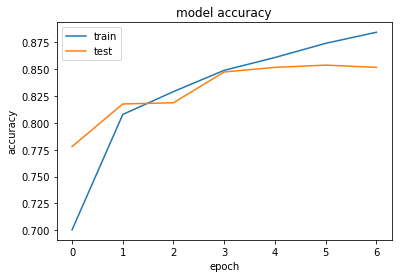

In [170]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



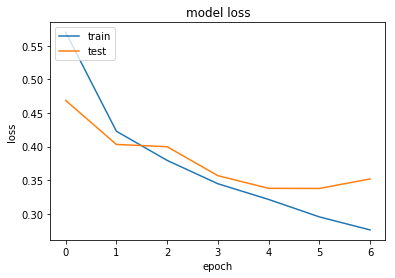

In [171]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [209]:
instance = X[4768]
print(instance)

i grew up watching and loving tng i just recently finished watching the entire series st voyager on dvd which may have heightened my sense of disgust with this episode as the difference in style and approach between the two shows couldn t be more stark the idea may have been good if used as an opportunity to further expand riker s character which is how it probably would have been treated on voy they could have featured memories that would be new to the audience rather than simply regurgitating old show clips the in and out transitions between the memories and the present in this episode start as cliché in the beginning and very quickly become intolerable as the tired pattern wears on and on bar none worst episode ever 


In [210]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

c  =model.predict(instance)
print(c)

[[0.2841966]]


In [203]:
if c[0] in range(0.01, 0.49):
    print(Positive)
elif c[0] in range(0.50, 0.65):
    print(neutral)
else:
    print(negative)

1